### <p style="text-align: center;">Community Segmentation</p>
# <p style="text-align: center;">Country Clustering</p>
#### <p style="text-align: center;">Jeffrey D Nelson and David N Campbell</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set seaborn defaults
sns.set()

df = pd.read_csv(r'data/country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [2]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Data Preprocessing

Before we can train any models, we must preprocess the data. First, we handle non-numeric features.

In this case, there is only one non-numeric feature, `country`. This was found using `df.select_dtypes(exclude=np.number).columns`. This feature is irrelevant, so we just drop it.

In [3]:
labels = df['country']
df = df.drop(columns=['country'])

Luckily, in this dataset there are no missing values, so there is no need to substitute or guess the missing data! 

### Scaling

After a few iterations, we realized that our clustering was performing poorly due to outliers in the dataset.  To scale this dataset we just used a standard scaler.

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

<AxesSubplot:>

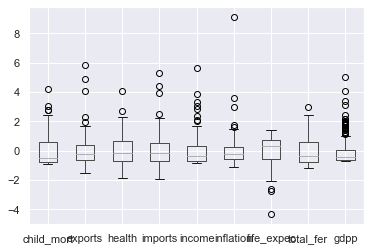

In [5]:
df_scaled.boxplot()

### Feature Correlations

The correlation between features is an important relationship to explore, and a great way to visualize these correlations is using a heat map, which seaborn makes simple.

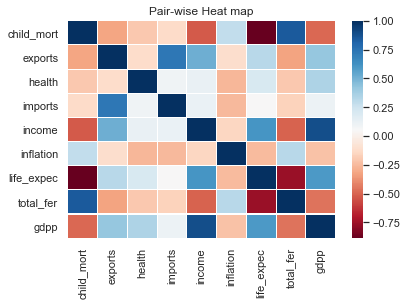

In [6]:
import seaborn as sns

g = sns.heatmap(df_scaled.corr(), annot=False, linewidths=0.1, vmax=1.0, linecolor='white', cmap=plt.cm.RdBu)
g.set_title("Pair-wise Heat map")
plt.show()

From the chart up, there are many interesting correlations, but some of the strongest are listed below:
- life expecency is negatively correlated with child mortality.  This makes sense, seeing as more children dying would descrese the life expectency
- exports are strongly correlated with imports.  This makes sense indicating that a country's econony scales with imports and exports together. 
- income and gdp are highly correlated.  This makes sense because the more individuals have to spend on average, the more goods that are produced to meet that demand. 
-child mortality is negatively correlated with income.  This makes sense because country's that can't pay for child healthcare intuitively indicates children would die more often, unfortately.

## PCA

Since there are so many features, we use PCA to decompose to the subset that captures the majority of the variance in the dataset.

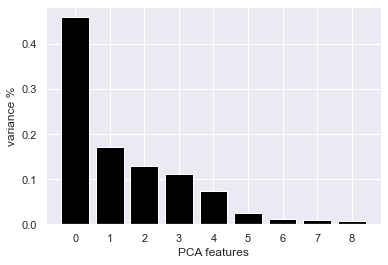

In [7]:
from sklearn.decomposition import PCA

num_features = len(df_scaled.columns)

pca = PCA(n_components=num_features)
principal_components = pca.fit_transform(df_scaled)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

it is recommended that using PCA we choose as many features are needed to explain at least 80% of the variance.  In the plot above, one can see that we will need the first 3 principle components to explain that amount of variance in this dataset.

In [8]:
pca = PCA(n_components=3)
df_scaled_pca = pca.fit_transform(df_scaled)

pc_df = pd.DataFrame(pca.components_.T, columns=['PC-1', 'PC-2', 'PC-3'], index=df_scaled.columns)
pc_df

,PC-1,PC-2,PC-3
child_mort,-0.419519,0.192884,-0.029544
exports,0.283897,0.613163,0.144761
health,0.150838,-0.243087,-0.596632
imports,0.161482,0.671821,-0.299927
income,0.398441,0.022536,0.301548
inflation,-0.193173,-0.008404,0.642520
life_expec,0.425839,-0.222707,0.113919
total_fer,-0.403729,0.155233,0.019549
gdpp,0.392645,-0.046022,0.122977


## K-Means

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
clusters = [ i for i in range(2, 15) ]

for i in clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_scaled_pca)
    score = silhouette_score(df_scaled_pca, kmeans.predict(df_scaled_pca))
    print("Silhouette score for {num} clusters: {score}".format(num=i, score=score))
    silhouette_scores.append(score)

Silhouette score for 2 clusters: 0.3486469452367987
Silhouette score for 3 clusters: 0.36897078470659267
Silhouette score for 4 clusters: 0.28690631542673184
Silhouette score for 5 clusters: 0.2902046922169579
Silhouette score for 6 clusters: 0.3065226605998928
Silhouette score for 7 clusters: 0.30887522553305435
Silhouette score for 8 clusters: 0.2973416756110241
Silhouette score for 9 clusters: 0.3121520188230873
Silhouette score for 10 clusters: 0.3171023367829402
Silhouette score for 11 clusters: 0.29630611110971494
Silhouette score for 12 clusters: 0.2968122930085333
Silhouette score for 13 clusters: 0.3016489388899207
Silhouette score for 14 clusters: 0.28887206799043064


In [10]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_scaled_pca)
kmeans.cluster_centers_

array([[ 1.2049172 , -0.46185337,  0.04780099],
       [-1.89291832,  0.30749252, -0.05888507],
       [ 4.33037993,  4.19320675, -0.05514727]])

In [11]:
# ColumnTransformer has no inverse transform...
inverse_array = pd.DataFrame(pca.inverse_transform(kmeans.cluster_centers_), columns=df.columns)
inverse_center_df = pd.DataFrame(scaler.inverse_transform(inverse_array), columns=df.columns)
inverse_center_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,14.306792,42.907290,7.542782,43.751284,26449.115895,5.693394,76.065375,2.106947,22105.387879
1,72.654582,31.341987,5.925265,44.924690,2440.349632,11.209554,62.741922,4.171723,-1008.638749
2,-2.189130,144.757844,5.903117,132.163890,51803.972690,-1.779019,78.570199,1.290059,40384.605524


In [12]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


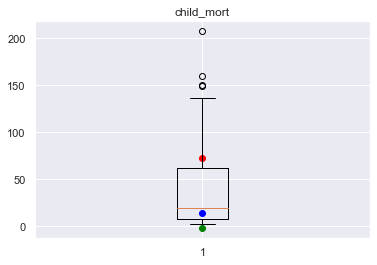

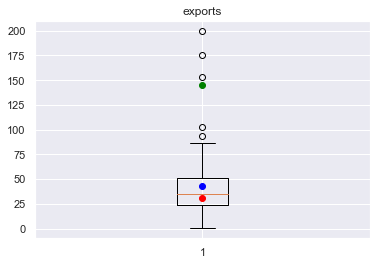

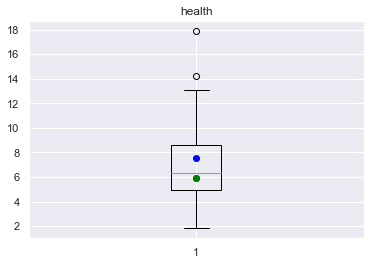

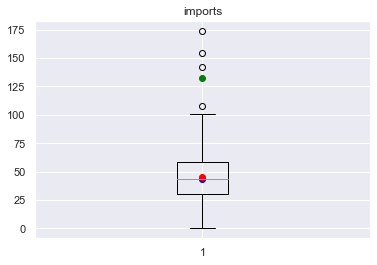

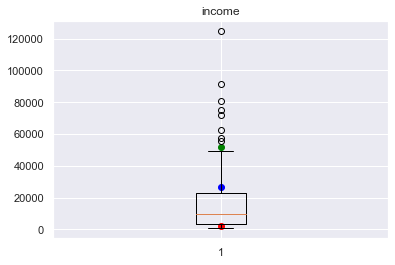

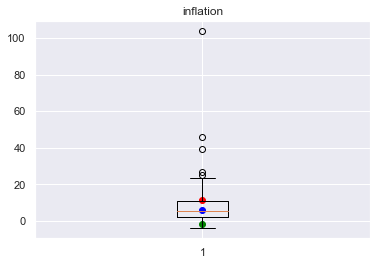

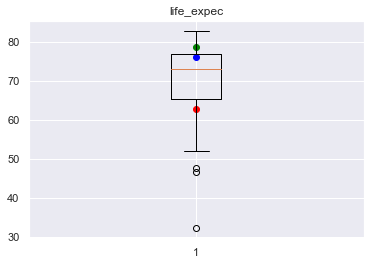

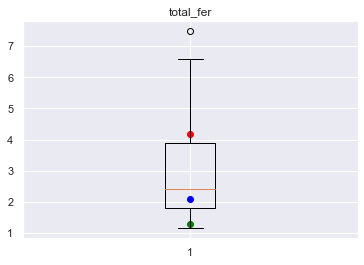

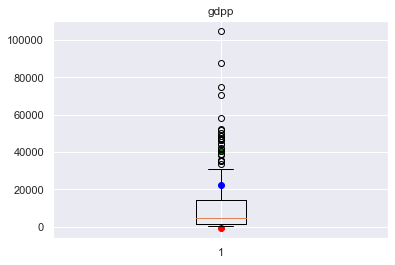

In [13]:
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i in range (len(df.columns)):
    label = df.columns[i]
    row = i // 3
    col = i % 3
    plt.figure()
    plt.title(label)
    plt.boxplot(df[label])
    for j in range(len(inverse_center_df)):
        plt.scatter(1, inverse_center_df[label][j], color=colors[j])

In [27]:
val = kmeans.predict(df_scaled_pca)
print("Cluster 0 Occurences: ", np.count_nonzero(val == 0), colors[0])
print("Cluster 1 Occurences: ", np.count_nonzero(val == 1), colors[1])
print("Cluster 2 Occurences: ", np.count_nonzero(val == 2), colors[2])

Cluster 0 Occurences:  92 blue
Cluster 1 Occurences:  70 red
Cluster 2 Occurences:  5 green


### Analysis of Clusters

The three clusters can be characterized by the following three groups:

- *about 92 nations:* these are characterized by general higher income and GDP.  Looking at the mean centers above relative to the box plot of the whole data set, the data set indicates that nations that have higher income and GDP have higher life expectency and lower child mortality rate.
- *about 70 nations:* these are characteruized by general lower income and GDP.  Looking at the mean centers above relative to the box plot of the whole data set, the data set indicates that nations that have lower income, GDP, imports and exports, suffer _severely_ higher child mortality rates and _severely_low life expectencies.  It appears that these nations don't have the economics means viable to increase quality of living and healthcare that the previous group had.
- *about 5 nations:* these nations are the richest of the rich nations, where they have extraordinarely high GDP, imports and export with low inflation.  They are the outliers that have a bunch of money per capita.

Below are print outs of the countries that are members of each cluster:

In [15]:
print("Countries belonging to Cluster 0: (%s)" % colors[0])
for i in range(len(df_scaled_pca)):
    if (val[i] == 0):
        print(labels[i])

Countries belonging to Cluster 0: (blue)
Albania
Algeria
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Barbados
Belarus
Belgium
Belize
Bosnia and Herzegovina
Brazil
Brunei
Bulgaria
Canada
Cape Verde
Chile
China
Colombia
Costa Rica
Croatia
Cyprus
Czech Republic
Denmark
Dominican Republic
Ecuador
El Salvador
Estonia
Finland
France
Georgia
Germany
Greece
Grenada
Hungary
Iceland
Iran
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kuwait
Latvia
Lebanon
Libya
Lithuania
Macedonia, FYR
Malaysia
Maldives
Mauritius
Moldova
Montenegro
Morocco
Netherlands
New Zealand
Norway
Oman
Panama
Paraguay
Peru
Poland
Portugal
Qatar
Romania
Russia
Saudi Arabia
Serbia
Slovak Republic
Slovenia
South Korea
Spain
Sri Lanka
St. Vincent and the Grenadines
Suriname
Sweden
Switzerland
Thailand
Tunisia
Turkey
Ukraine
United Arab Emirates
United Kingdom
United States
Uruguay
Venezuela
Vietnam


In [16]:
print("Countries belonging to Cluster 1: (%s)" % colors[1])
for i in range(len(df_scaled_pca)):
    if (val[i] == 1):
        print(labels[i])

Countries belonging to Cluster 1: (red)
Afghanistan
Angola
Bangladesh
Benin
Bhutan
Bolivia
Botswana
Burkina Faso
Burundi
Cambodia
Cameroon
Central African Republic
Chad
Comoros
Congo, Dem. Rep.
Congo, Rep.
Cote d'Ivoire
Egypt
Equatorial Guinea
Eritrea
Fiji
Gabon
Gambia
Ghana
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
India
Indonesia
Iraq
Kenya
Kiribati
Kyrgyz Republic
Lao
Lesotho
Liberia
Madagascar
Malawi
Mali
Mauritania
Micronesia, Fed. Sts.
Mongolia
Mozambique
Myanmar
Namibia
Nepal
Niger
Nigeria
Pakistan
Philippines
Rwanda
Samoa
Senegal
Sierra Leone
Solomon Islands
South Africa
Sudan
Tajikistan
Tanzania
Timor-Leste
Togo
Tonga
Turkmenistan
Uganda
Uzbekistan
Vanuatu
Yemen
Zambia


In [17]:
print("Countries belonging to Cluster 2: (%s)" % colors[2])
for i in range(len(df_scaled_pca)):
    if (val[i] == 2):
        print(labels[i])

Countries belonging to Cluster 2: (green)
Ireland
Luxembourg
Malta
Seychelles
Singapore


You can see from the data above, the data is easily broken into countries that are rich, with thriving economies, and countries that are poor that have less thriving economies.  It also shows that countries with better economies have higher life expectency and lower child mortality rate.

In some cases, we may want to see which countries are extremely poor and need more aid than others.  Even though the silhouette score is lower, let us experiment using five 5 clusters to see if we can further find even poorer nations.

## Kmeans (Again) - More Clusters

In [18]:
num_clusters = 5
kmeans2 = KMeans(n_clusters=num_clusters)
kmeans2.fit(df_scaled_pca)
kmeans2.cluster_centers_

array([[-1.13231963, -0.51184594,  1.23351409],
       [ 2.56872337, -0.8250807 ,  0.05511883],
       [-2.44936932,  0.53834127, -0.48693092],
       [ 5.46022462,  5.43247334,  0.21164795],
       [ 0.47301901,  0.03964331, -0.27108661]])

In [19]:
# ColumnTransformer has no inverse transform...
inverse_array2 = pd.DataFrame(pca.inverse_transform(kmeans2.cluster_centers_), columns=df.columns)
inverse_center_df2 = pd.DataFrame(scaler.inverse_transform(inverse_array2), columns=df.columns)
inverse_center_df2

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,51.935188,28.626274,4.673204,25.246998,15400.751217,18.485166,68.537010,3.554418,8042.147791
1,-11.523639,47.430977,8.335999,43.124020,36778.423072,2.998614,81.939339,1.191023,32212.742130
2,84.339632,29.199577,6.241123,49.597957,-4201.919536,9.423438,59.752733,4.552254,-6157.299979
3,-11.953212,175.346849,5.108910,154.731883,62539.556572,-2.382373,80.658548,0.899812,48048.677805
4,30.920629,44.370894,7.427633,51.339233,19213.137013,4.979657,71.989575,2.661019,15715.568509


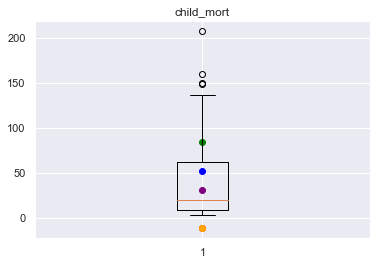

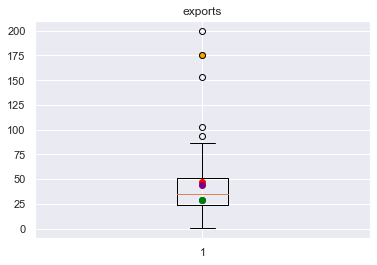

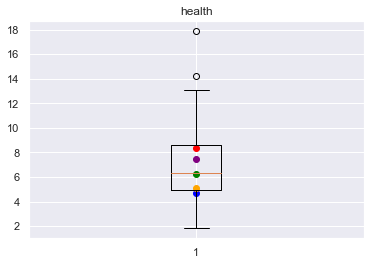

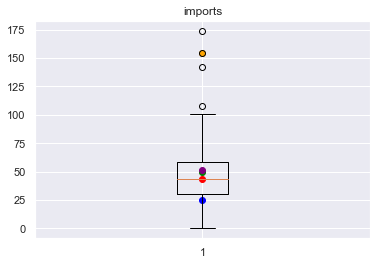

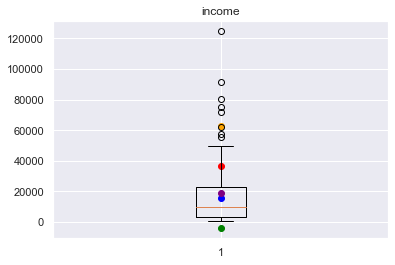

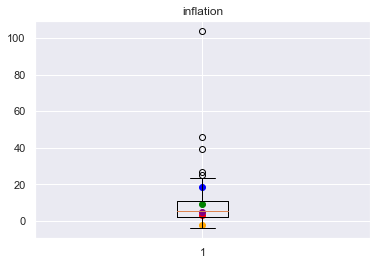

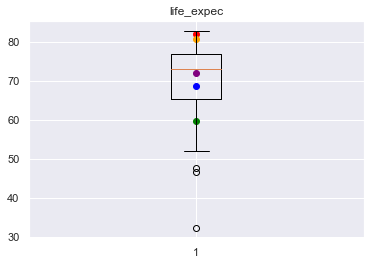

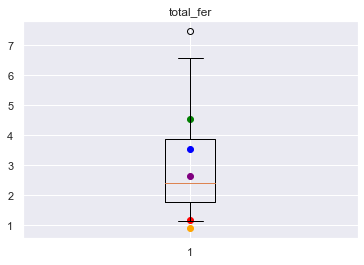

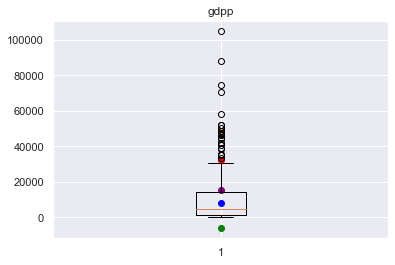

In [20]:
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i in range (len(df.columns)):
    label = df.columns[i]
    row = i // 3
    col = i % 3
    plt.figure()
    plt.title(label)
    plt.boxplot(df[label])
    for j in range(len(inverse_center_df2)):
        plt.scatter(1, inverse_center_df2[label][j], color=colors[j])

In [21]:
val2 = kmeans2.predict(df_scaled_pca)
print("Cluster 0 Occurences: ", np.count_nonzero(val2 == 0), colors[0])
print("Cluster 1 Occurences: ", np.count_nonzero(val2 == 1), colors[1])
print("Cluster 2 Occurences: ", np.count_nonzero(val2 == 2), colors[2])
print("Cluster 3 Occurences: ", np.count_nonzero(val2 == 3), colors[3])
print("Cluster 4 Occurences: ", np.count_nonzero(val2 == 4), colors[4])

Cluster 0 Occurences:  28 blue
Cluster 1 Occurences:  31 red
Cluster 2 Occurences:  39 green
Cluster 3 Occurences:  3 orange
Cluster 4 Occurences:  66 purple


### Analysis of Clusters

In general, though the message the data is saying is largely the same, by applying more clusters one can create more discrete groups to separate out the countries.  As expected we can really see which nations are the poorest from the data and which countries are the most affluent.  One could use this study to optimize aid allocation to the various nations depending on how much they need it.

Below are printouts of membership of each group in the larger amount of clusters scheme.

In [22]:
print("Countries belonging to Cluster 0: (%s)" % colors[0])
for i in range(len(df_scaled_pca)):
    if (val2[i] == 0):
        print(labels[i])

Countries belonging to Cluster 0: (blue)
Algeria
Argentina
Azerbaijan
Bangladesh
Bolivia
Egypt
Equatorial Guinea
Eritrea
Gabon
India
Indonesia
Iran
Iraq
Kazakhstan
Mongolia
Myanmar
Nepal
Nigeria
Pakistan
Philippines
Russia
Saudi Arabia
Sri Lanka
Sudan
Timor-Leste
Uzbekistan
Venezuela
Yemen


In [23]:
print("Countries belonging to Cluster 1: (%s)" % colors[1])
for i in range(len(df_scaled_pca)):
    if (val2[i] == 1):
        print(labels[i])

Countries belonging to Cluster 1: (red)
Australia
Austria
Belgium
Brunei
Canada
Cyprus
Czech Republic
Denmark
Finland
France
Germany
Greece
Iceland
Ireland
Israel
Italy
Japan
Kuwait
Netherlands
New Zealand
Norway
Portugal
Qatar
Slovenia
South Korea
Spain
Sweden
Switzerland
United Arab Emirates
United Kingdom
United States


In [24]:
print("Countries belonging to Cluster 2: (%s)" % colors[2])
for i in range(len(df_scaled_pca)):
    if (val2[i] == 2):
        print(labels[i])

Countries belonging to Cluster 2: (green)
Afghanistan
Angola
Benin
Burkina Faso
Burundi
Cameroon
Central African Republic
Chad
Comoros
Congo, Dem. Rep.
Congo, Rep.
Cote d'Ivoire
Gambia
Ghana
Guinea
Guinea-Bissau
Haiti
Kenya
Kiribati
Lao
Lesotho
Liberia
Madagascar
Malawi
Mali
Mauritania
Mozambique
Namibia
Niger
Rwanda
Senegal
Sierra Leone
Solomon Islands
South Africa
Tajikistan
Tanzania
Togo
Uganda
Zambia


In [25]:
print("Countries belonging to Cluster 3: (%s)" % colors[3])
for i in range(len(df_scaled_pca)):
    if (val2[i] == 3):
        print(labels[i])

Countries belonging to Cluster 3: (orange)
Luxembourg
Malta
Singapore


In [26]:
print("Countries belonging to Cluster 4: (%s)" % colors[4])
for i in range(len(df_scaled_pca)):
    if (val2[i] == 4):
        print(labels[i])

Countries belonging to Cluster 4: (purple)
Albania
Antigua and Barbuda
Armenia
Bahamas
Bahrain
Barbados
Belarus
Belize
Bhutan
Bosnia and Herzegovina
Botswana
Brazil
Bulgaria
Cambodia
Cape Verde
Chile
China
Colombia
Costa Rica
Croatia
Dominican Republic
Ecuador
El Salvador
Estonia
Fiji
Georgia
Grenada
Guatemala
Guyana
Hungary
Jamaica
Jordan
Kyrgyz Republic
Latvia
Lebanon
Libya
Lithuania
Macedonia, FYR
Malaysia
Maldives
Mauritius
Micronesia, Fed. Sts.
Moldova
Montenegro
Morocco
Oman
Panama
Paraguay
Peru
Poland
Romania
Samoa
Serbia
Seychelles
Slovak Republic
St. Vincent and the Grenadines
Suriname
Thailand
Tonga
Tunisia
Turkey
Turkmenistan
Ukraine
Uruguay
Vanuatu
Vietnam
